In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import string
import theano
import therapy
import importlib
import itertools

sns.set()
plt.ion()

# 8 Markov Chain Monte Carlo

## 8.1. Good King Markov and His island kingdom

In [87]:
# Code 8.1
rs = np.random.RandomState(seed=42)
num_weeks = 100000

positions = np.zeros(num_weeks, dtype=int)

current = 10

for i in range(len(positions)):
    # record current position
    positions[i] = current

    # flip coin to generate a proposal
    proposal = current + rs.choice([-1, 1])

    # now make sure he loops around the archipelago
    if proposal < 1:
        proposal = 10

    if proposal > 10:
        proposal = 1

    # move?
    prob_move = proposal / current

    current = proposal if rs.uniform() < prob_move else current

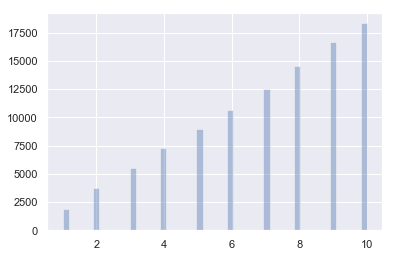

In [90]:
sns.distplot(positions, kde=False)

# change of pace
from here on will only do exercises

## 8.6 Practice

**Easy**

### 8E1.

(1) No, samples may also be continuous

(2) Unsure what 'likelihood function' means in this specific case. If it means likelihood function of data given hypothesis, then no, this is not a requirement either.

(3) Yes, the proposal distribution must be symmetric

### 8E2.
Gibbs sampling is more efficient, i.e. can generate an image of the posterior that is just as good as the simple Metropolis algorithm in fewer samples, by allowing for an asymmetrical proposal distribution, and by using adaptive proposals. The distribution of proposes parameters then depends on current parameter values through using conjugate prior/likelihood combinations. These conjugate pairs have analytical solutions for posterior distributions of individual parameters, which can be used to make more efficient jumps around the joint posterior of all parameters.

On the flipside, Gibbs sampling only works for conjugate pairs, even though these combinations of prior and likelihood might not make the most sense for a model. Furthermore, Gibbs sampling can become very inefficient for large models with many parameters

### 8E3.
Hamiltonian Monte Carlo can only handle continuous parameters, as it essentially simulates a frictionless particle gliding over parameter space. It can't glide over non-continuous space. As a consequence, it can't be used in some scenarios, e.g. imputation of discrete missing data.

### 8E4.
n_eff is an estimate of the number of independent samples. I'm not sure how that differs from the actual number of samples. My guess is that only independent samples really tell us something about the posterior?

### 8E5.
Rhat should approach 1 from above if a chain is sampling the posterior correctly.

### 8E6.
Looking for stationarity and good mixing. Stationarity: path stays within posterior. Mean value of chain stable beggining to end. Well-mixing: consecutive values not highly correlated. Visually indicated by rapid zig-zagging.


[good plot]
[bad plot]

**Medium**

### 8M1.

In [13]:
d = (
    pd
    .read_csv('./data/rugged.csv', sep=';')
    .set_index('isocode')
    .assign(log_gdp=lambda df: np.log(df['rgdppc_2000']))
)

d.head()

,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,lon,...,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_gdp
isocode,,,,,,,,,,,,,,,,,,,,,
ABW,533,Aruba,0.462,0.380,1.226,0.144,0.000,18.0,12.508,-69.970,...,0,0,0.0,NaN,NaN,NaN,NaN,614.0,NaN,NaN
AFG,4,Afghanistan,2.518,1.469,7.414,0.720,39.004,65209.0,33.833,66.026,...,0,0,0.0,NaN,NaN,NaN,NaN,1870829.0,0.0,NaN
AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,17.551,...,0,1,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.0,7.492609
AIA,660,Anguilla,0.013,0.010,0.026,0.006,0.000,9.0,18.231,-63.064,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,20.070,...,0,0,0.0,NaN,NaN,NaN,NaN,200000.0,100.0,8.216929


In [47]:
d.shape

(234, 51)

In [48]:
dd = d.dropna(subset=["rgdppc_2000"])

In [49]:
dd.shape

(170, 51)

In [50]:
with pm.Model() as m:
    data = dd
    shared = therapy.create_theano_shared_from_df(data)
    pm.HalfCauchy('sigma', 2)
    pm.Normal('bAR', 0, 10)
    pm.Normal('bA', 0, 10)
    pm.Normal('bR', 0, 10)
    pm.Normal('a', 0, 100)
    pm.Deterministic(
        'mu', 
        m.a 
        + m.bR * shared['rugged'] 
        + m.bA * shared['cont_africa']
        + m.bAR * shared['cont_africa'] * shared['rugged']
    )
    pm.Normal('log_gdp', m.mu, m.sigma, observed=shared['log_gdp'])

m_8_1 = therapy.Model(m, shared, 'm_8_1')

In [51]:
m_8_1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:04<00:00, 463.70draws/s]


In [52]:
therapy.interesting_summary(m_8_1).sort_index()

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,9.225243,0.142450,0.007061,8.936171,9.496039,366.198672,1.001166
bA,-1.950683,0.244787,0.011251,-2.439478,-1.502075,426.807821,1.000004
bAR,0.396214,0.140606,0.006849,0.125140,0.679470,372.776432,1.000578
bR,-0.202482,0.079914,0.003955,-0.357712,-0.047812,345.173683,1.000935
sigma,0.948151,0.050163,0.001672,0.853032,1.044445,886.956590,1.000043
